In [20]:
# Angular variance resultant for generated posts
from pathlib import Path
import json
from typing import List
import math
import torch
from transformers import AutoTokenizer, AutoModel

# Resolve paths relative to this notebook's directory
notebooks_dir = Path.cwd()
backend_dir = notebooks_dir.parent
base = backend_dir / 'data' / 'generated' / 'experiment_ablation' / 'google' / 'gemma-3-27b-it' / 'personal'

summary_path = base / 'summary.json'
soft_candidates = ['soft prompt.json', 'softprompt.json', 'soft_prompt.json']
soft_path = None
for name in soft_candidates:
    candidate = base / name
    if candidate.exists():
        soft_path = candidate
        break

print('Summary path:', summary_path)
print('Soft prompt path:', soft_path)

assert summary_path.exists(), f"Missing file: {summary_path}"
assert soft_path and soft_path.exists(), "Missing soft prompt file (tried: 'soft prompt.json', 'softprompt.json', 'soft_prompt.json')"


def load_posts(path: Path) -> List[dict]:
    with path.open('r', encoding='utf-8') as f:
        data = json.load(f)
    if not isinstance(data, list):
        return []
    return [p for p in data if isinstance(p, dict)]


def extract_texts(posts: List[dict]) -> List[str]:
    texts: List[str] = []
    for p in posts:  # align with UI cap
        title = (p.get('title') or '').strip()
        body = (p.get('self_text') or '').strip()
        if title and body:
            texts.append(f"{title}\n\n{body}")
        else:
            texts.append(title or body)
    return [t for t in texts if t]


@torch.inference_mode()
def embed_texts(texts: List[str], model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', batch_size: int = 32) -> torch.Tensor:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        summed = torch.sum(last_hidden_state * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-6)
        return summed / counts

    all_embs: List[torch.Tensor] = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        pooled = mean_pool(out.last_hidden_state, enc['attention_mask'])
        all_embs.append(pooled.cpu())
    embs = torch.cat(all_embs, dim=0)
    # L2 normalize (unit vectors)
    embs = torch.nn.functional.normalize(embs, p=2, dim=1)
    return embs


def angular_resultant_and_variance(unit_vectors: torch.Tensor) -> tuple[float, float]:
    # unit_vectors: [N, D], L2-normalized rows
    mean_vec = unit_vectors.mean(dim=0)
    R = float(torch.linalg.vector_norm(mean_vec))  # mean resultant length in [0,1]
    V = 1.0 - R  # angular variance resultant
    return R, V


# Load
summary_posts = load_posts(summary_path)
soft_posts = load_posts(soft_path)

summary_texts = extract_texts(summary_posts)
soft_texts = extract_texts(soft_posts)

print(f"Summary posts used: {len(summary_texts)}")
print(f"Soft prompt posts used: {len(soft_texts)}")

# Embed
summary_embs = embed_texts(summary_texts)
soft_embs = embed_texts(soft_texts)
all_embs = torch.cat([summary_embs, soft_embs], dim=0) if len(soft_embs) else summary_embs

# Compute metrics
R_sum, V_sum = angular_resultant_and_variance(summary_embs)
R_soft, V_soft = angular_resultant_and_variance(soft_embs)
R_all, V_all = angular_resultant_and_variance(all_embs)

print({
    'summary': {'R': round(R_sum, 6), 'angular_variance_resultant': round(V_sum, 6)},
    'soft_prompt': {'R': round(R_soft, 6), 'angular_variance_resultant': round(V_soft, 6)},
    'combined': {'R': round(R_all, 6), 'angular_variance_resultant': round(V_all, 6)},
})


Summary path: /Users/einar/Developer/Projects/Web/slop/backend/data/generated/experiment_ablation/google/gemma-3-27b-it/personal/summary.json
Soft prompt path: /Users/einar/Developer/Projects/Web/slop/backend/data/generated/experiment_ablation/google/gemma-3-27b-it/personal/soft prompt.json
Summary posts used: 50
Soft prompt posts used: 50
{'summary': {'R': 0.778335, 'angular_variance_resultant': 0.221665}, 'soft_prompt': {'R': 0.434592, 'angular_variance_resultant': 0.565408}, 'combined': {'R': 0.527274, 'angular_variance_resultant': 0.472726}}


In [ ]:
# test

from openai import OpenAI
import os, dotenv

dotenv.load_dotenv()

client = OpenAI()


In [9]:
response = client.embeddings.create(
    input="title: Is there a way/mod that would dissable military clothing ?\n self_text: I am looking for a way/mod that would dissable military clothing a for rp so it would feel more authentic.\n subreddit: projectzomboid<end_of_turn>",
    model="text-embedding-3-large"
)

embedding1 = response.data[0].embedding

response = client.embeddings.create(
    input="Is anyone else experiencing extreme lag spikes in Warzone? self_text: Ever since the latest patch, I've been getting massive lag spikes every few minutes, even though my ping stays relatively stable. It's making the game nearly unplayable. I've tried restarting my router, verifying game files, and lowering my graphic settings, but nothing seems to fix it. Has anyone else encountered this issue, and if so, have you found a solution?\n subreddit: Warzone<end_of_turn>",
    model="text-embedding-3-large"
)

embedding2 = response.data[0].embedding

response = client.embeddings.create(
    input="title: Is it normal for my cat to knead my hair?\n self_text: My cat loves to climb on my lap and knead, which is cute, but lately she’s been kneading *my hair* instead of a blanket or my clothes. It doesn’t hurt, but it’s…weird. Is this a common behavior? Should I discourage it?\n subreddit: cats<end_of_turn>",
    model="text-embedding-3-large"
)

embedding3 = response.data[0].embedding

response = client.embeddings.create(
    input="title: Dog keeps stealing socks\n self_text: My golden retriever loves to steal socks, and then hides them all over the house. I’ve tried redirecting with toys, but he’s obsessed with socks. Any advice on how to stop this behavior?\n subreddit: dogs<end_of_turn>",
    model="text-embedding-3-large"
)

embedding4 = response.data[0].embedding


In [5]:
response = client.embeddings.create(
    input="title: My partner keeps forgetting to reimburse me for shared expenses\n self_text: Okay, so we’ve been together 2 years and live together. We don’t have joint finances – mostly because we both had messy situations before meeting and are hesitant to fully merge everything. But we *do* split bills pretty evenly. The problem is, I often end up fronting costs for things like groceries, household supplies, or even date nights, with the understanding he’ll Venmo me his half. And…he just doesn't. Not consistently, anyway. He’ll say he “forgot,” or that money is tight (even though he just bought a new video game). I've brought it up multiple times, trying to be calm and rational (\"Hey, could you send over $40 for groceries?\"), but it always feels like pulling teeth. Last week I covered almost all of our gas for a road trip and still haven’t seen a dime. It’s not huge amounts individually, but it adds up! And honestly, it feels disrespectful, like my time and effort aren't valued. Is it ridiculous to feel this way? Am I supposed to just constantly remind him? I'm starting to resent having to ask at all. AITA for expecting him to follow through when we agree on splitting costs? Any advice on how to handle this without blowing up at him?\n subreddit: relationships<end_of_turn>",
    model="text-embedding-3-large"
)

embedding5 = response.data[0].embedding
response  = client.embeddings.create(
    input=" title: My (32F) partner (35M) keeps \"forgetting\" to reimburse me for shared expenses - am I being unreasonable to be frustrated?\n self_text: Okay, so we’ve been together 3 years, living together for 1.5. We don’t have joint finances – both very independent people which was great at first. But lately, it feels like I’m constantly fronting costs for things *we* both benefit from (groceries, utilities, date nights, even pet supplies). He always says he’ll Venmo me, genuinely apologizes for forgetting, then…doesn’t. Or remembers weeks later after I’ve brought it up again. It’s not huge amounts each time ($20-$50 usually), but it adds up! And honestly, it feels disrespectful now. Like my time & money aren't valued. I’ve tried gently reminding him, then more directly asking, and even suggesting we alternate who pays for what each week. Nothing sticks. AITA for getting increasingly annoyed by this? Is there a way to address this without starting a massive fight? I just want a fair split and some acknowledgement that I’m contributing equally.\n subreddit: relationships<end_of_turn>",
    model="text-embedding-3-large"
)

embedding6 = response.data[0].embedding



In [7]:
import numpy as np

# calculate cosine similarity between embedding1 and embedding2
# cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
# print(cosine_similarity)

# # calculate cosine similarity between embedding1 and embedding3
# cosine_similarity = np.dot(embedding1, embedding3) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding3))
# print(cosine_similarity)

# # calculate cosine similarity between embedding3 and embedding4
# cosine_similarity = np.dot(embedding3, embedding4) / (np.linalg.norm(embedding3) * np.linalg.norm(embedding4))
# print(cosine_similarity)

# calculate cosine similarity between embedding5 and embedding6
cosine_similarity = np.dot(embedding5, embedding6) / (np.linalg.norm(embedding5) * np.linalg.norm(embedding6))
print(cosine_similarity)






0.9295794081681001


In [14]:
# Calculate variance across all embeddings
embeddings = [embedding1, embedding2, embedding3, embedding4, embedding5, embedding6]

def angular_variance_resultant(X):
    """
    1 - resultant length for L2-normalized embeddings.
    """
    X = np.asarray(X, dtype=float)
    Y = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    R = np.linalg.norm(Y.mean(axis=0))
    return 1.0 - R

variance = angular_variance_resultant(embeddings)
print(variance)


0.34554694215198034


In [ ]:
%pip install umap-learn hdbscan matplotlib

/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


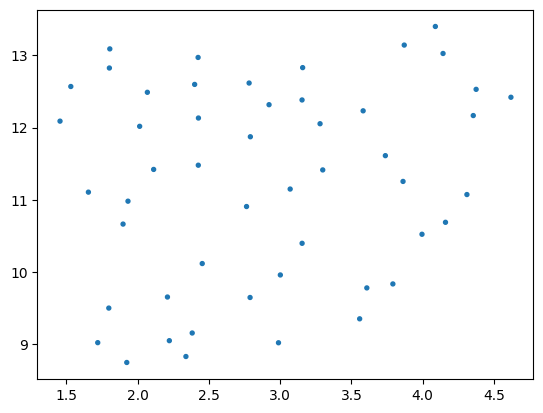

0


/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


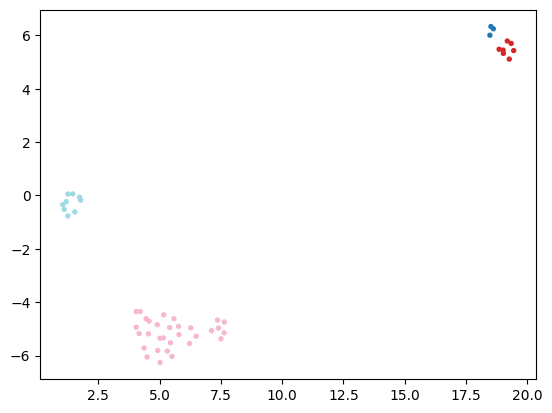

3


In [25]:
import numpy as np
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt

def plot_embeddings(embeddings):        
    # X = (n, d) embeddings, already normalized
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(embeddings)

    # Cluster in high-d space
    clusterer = hdbscan.HDBSCAN()
    labels = clusterer.fit_predict(embeddings)

    # Plot
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab20", s=8)
    # plt.colorbar()
    plt.show()
    
    # Return number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters
    
print(plot_embeddings(soft_embs))   
print(plot_embeddings(summary_embs))


## Load judgements

In [53]:
def load_posts(path: Path) -> List[object]:
    with path.open('r', encoding='utf-8') as f:
        data = json.load(f)
    if not isinstance(data, list):
        return []
    # keep both dict and string items; filter out other types
    return [p for p in data if isinstance(p, (dict, str))]


def parse_string_post(s: str) -> dict | None:
    try:
        text = str(s)
    except Exception:
        return None
    title = ''
    body_lines: List[str] = []
    subreddit = ''
    in_body = False
    for line in text.splitlines():
        t = line.lstrip()
        if t.lower().startswith('title:'):
            title = t.split(':', 1)[1].strip()
            in_body = False
            continue
        if t.lower().startswith('self_text:') or t.lower().startswith('self text:'):
            body_lines.append(t.split(':', 1)[1].lstrip())
            in_body = True
            continue
        if t.lower().startswith('subreddit:'):
            subreddit = t.split(':', 1)[1].strip()
            in_body = False
            continue
        if in_body:
            body_lines.append(line)
    self_text = '\n'.join(body_lines).strip()
    if not (title or self_text):
        return None
    return {'title': title, 'self_text': self_text, 'subreddit': subreddit}


def extract_texts(posts: List[object]) -> List[str]:
    texts: List[str] = []
    for p in posts:
        title = ''
        body = ''
        subreddit = ''
        if isinstance(p, dict):
            title = (p.get('title') or '').strip()
            body = (p.get('self_text') or '').strip()
            subreddit = (p.get('subreddit') or '').strip()
        elif isinstance(p, str):
            parsed = parse_string_post(p)
            if not parsed:
                continue
            title = parsed['title']
            body = parsed['self_text']
            subreddit = parsed.get('subreddit') or ''
        else:
            continue
        if title and body:
            texts.append(f"{title}\n\n{body}\n\n{subreddit}")
        else:
            texts.append(title or body)
    return [t for t in texts if t]

In [38]:
# clean up json to add model, experiment, dataset fields based on file path
with open('../data/judgements/experiment_ablation_judgements.json', 'r') as f:
    data = json.load(f)
    for d in data:
        d['model'] = d['file_path'].split('/')[-4] + '/' + d['file_path'].split('/')[-3]
        d['dataset'] = d['file_path'].split('/')[-2]
        d['experiment'] = d['file_path'].split('/')[-1].split('.')[0]
    with open('../data/judgements/experiment_ablation_judgements_clean.json', 'w') as f:
        json.dump(data, f, indent=4)
    


In [39]:
# load into pandas dataframe
import pandas as pd
df = pd.read_json('../data/judgements/experiment_ablation_judgements_clean.json')
df.head()

,file_path,adherence,coherence,shown_count,unique,model,dataset,experiment
0,generated/experiment_ablation/google/gemma-3-4...,42,39,50,22,google/gemma-3-4b-it,alike,soft prompt
1,generated/experiment_ablation/google/gemma-3-4...,49,49,50,7,google/gemma-3-4b-it,alike,like history
2,generated/experiment_ablation/google/gemma-3-4...,40,34,50,0,google/gemma-3-4b-it,alike,self defined
3,generated/experiment_ablation/google/gemma-3-4...,31,24,50,0,google/gemma-3-4b-it,alike,summary
4,generated/experiment_ablation/google/gemma-3-4...,1,1,50,0,google/gemma-3-4b-it,college,summary


## Calculate variances

In [54]:
def angular_variance(unit_vectors: torch.Tensor) -> tuple[float, float]:
    # unit_vectors: [N, D], L2-normalized rows
    mean_vec = unit_vectors.mean(dim=0)
    R = float(torch.linalg.vector_norm(mean_vec))  # mean resultant length in [0,1]
    V = 1.0 - R  # angular variance resultant
    return V

@torch.inference_mode()
def embed_texts(texts: List[str], model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', batch_size: int = 32) -> torch.Tensor:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        summed = torch.sum(last_hidden_state * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-6)
        return summed / counts

    all_embs: List[torch.Tensor] = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        pooled = mean_pool(out.last_hidden_state, enc['attention_mask'])
        all_embs.append(pooled.cpu())
    embs = torch.cat(all_embs, dim=0)
    # L2 normalize (unit vectors)
    embs = torch.nn.functional.normalize(embs, p=2, dim=1)
    return embs

In [55]:
count = 0
for idx, row in df.iterrows():
    model = row['model']
    dataset = row['dataset']
    experiment = row['experiment']

    # load posts
    posts_path = f'../data/generated/experiment_ablation/{model}/{dataset}/{experiment}.json'
    posts = load_posts(Path(posts_path))
    variance = None
    try:
        texts = extract_texts(posts)
        if not texts:
            raise ValueError('no_texts')
        embs = embed_texts(texts)
        variance = angular_variance(embs)
        # update original DataFrame
        df.loc[idx, 'variance'] = variance
    except Exception as e:
        print(f'{model} {dataset} {experiment} {e}')

    print(f'{model} {dataset} {experiment} {variance}')

# persist updated DataFrame

df.to_json('../data/judgements/experiment_ablation_judgements_clean.json', orient='records', indent=4)


google/gemma-3-4b-it alike soft prompt 0.6657687127590179
google/gemma-3-4b-it alike like history 0.4634689688682556
google/gemma-3-4b-it alike self defined 0.18786484003067017
google/gemma-3-4b-it alike summary 0.17541402578353882
google/gemma-3-4b-it college summary 0.09758579730987549
google/gemma-3-4b-it college soft prompt 0.7001872956752777
google/gemma-3-4b-it college like history 0.7034116685390472
google/gemma-3-4b-it college self defined 0.3103201389312744
google/gemma-3-4b-it formatspecific like history 0.6295323669910431
google/gemma-3-4b-it formatspecific self defined 0.2685620188713074
google/gemma-3-4b-it formatspecific soft prompt 0.6728358864784241
google/gemma-3-4b-it formatspecific summary 0.25034523010253906
google/gemma-3-4b-it nerdy summary 0.3771069645881653
google/gemma-3-4b-it nerdy soft prompt 0.5809314250946045
google/gemma-3-4b-it nerdy self defined 0.1450396180152893
google/gemma-3-4b-it nerdy like history 0.37341296672821045
google/gemma-3-4b-it newmother 

## Clustering

In [ ]:
import numpy as np
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt

def plot_embeddings(embeddings):        
    # X = (n, d) embeddings, already normalized
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(embeddings)

    # Cluster in high-d space
    clusterer = hdbscan.HDBSCAN()
    labels = clusterer.fit_predict(embeddings)

    # Plot
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab20", s=8)
    # plt.colorbar()
    plt.show()
    
    # Return number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters
    
print(plot_embeddings(soft_embs))   
print(plot_embeddings(summary_embs))

In [ ]:
# Batch plot embeddings (16 subplots per image) with rows=datasets and cols=experiments; save PNGs
from pathlib import Path
import os
import math
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan

# Where to save
notebooks_dir = Path.cwd()
backend_dir = notebooks_dir.parent
out_dir = backend_dir / 'data' / 'judgements'
os.makedirs(out_dir, exist_ok=True)


def plot_embeddings_ax(embeddings, ax):
    # embeddings expected L2-normalized (embed_texts returns normalized)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(embeddings)
    clusterer = hdbscan.HDBSCAN()
    labels = clusterer.fit_predict(embeddings)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=8)
    ax.set_xticks([])
    ax.set_yticks([])


def make_title(dataset, experiment, model):
    return f"{dataset} / {experiment}\n{model}"


# Determine experiment columns (prefer a stable order)
preferred_experiments = [
    'soft prompt',
    'like history',
    'self defined',
    'summary',
]
all_experiments = list(df['experiment'].astype(str).unique())
# Compose the final 4-column order
exp_cols = [e for e in preferred_experiments if e in all_experiments]
for e in all_experiments:
    if e not in exp_cols:
        exp_cols.append(e)
exp_cols = exp_cols[:4]

# Rows are datasets; batch 4 datasets per page
datasets = list(df['dataset'].astype(str).unique())
datasets.sort()

page = 1
for start in range(0, len(datasets), 4):
    ds_batch = datasets[start:start+4]
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    axs = axs.reshape(4, 4)

    for r_idx, dataset in enumerate(ds_batch):
        for c_idx, experiment in enumerate(exp_cols):
            ax = axs[r_idx, c_idx]
            # Pick a matching row (first match) for this dataset+experiment
            match = df[(df['dataset'] == dataset) & (df['experiment'] == experiment)]
            if match.empty:
                ax.axis('off')
                ax.set_title(f"{dataset} / {experiment}\n[missing]", fontsize=9)
                continue
            row = match.iloc[0]
            model = row['model']
            posts_path = backend_dir / 'data' / 'generated' / 'experiment_ablation' / model / dataset / f"{experiment}.json"
            try:
                posts = load_posts(Path(posts_path))
                texts = extract_texts(posts)
                if not texts:
                    raise ValueError('no_texts')
                embs = embed_texts(texts)
                plot_embeddings_ax(embs, ax)
                ax.set_title(make_title(dataset, experiment, model), fontsize=9)
            except Exception as e:
                ax.axis('off')
                ax.set_title(f"{make_title(dataset, experiment, model)}\n[error: {e}]", fontsize=9)

    # Label column headers with experiments
    for c_idx, experiment in enumerate(exp_cols):
        axs[0, c_idx].set_title(f"{experiment}", fontsize=11, pad=20)
    # Label row headers (left side) with dataset
    for r_idx, dataset in enumerate(ds_batch):
        axs[r_idx, 0].set_ylabel(dataset, fontsize=11, labelpad=20)

    plt.tight_layout()
    out_path = out_dir / f"embeddings_page_{page}.png"
    plt.savefig(out_path, dpi=150)
    plt.close(fig)
    page += 1

print(f"Saved {page - 1} image(s) to {out_dir}")


In [60]:
# One model per PNG: 4x4 grid (rows=datasets, cols=experiments), no per-plot titles
from pathlib import Path
import os
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan

# Output directory
notebooks_dir = Path.cwd()
backend_dir = notebooks_dir.parent
out_dir = backend_dir / 'data' / 'judgements'
os.makedirs(out_dir, exist_ok=True)

preferred_experiments = [
    'soft prompt',
    'like history',
    'self defined',
    'summary',
]


def plot_embeddings_ax(embeddings, ax):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(embeddings)
    labels = hdbscan.HDBSCAN().fit_predict(embeddings)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=4)
    ax.set_xticks([])
    ax.set_yticks([])


models = sorted(df['model'].astype(str).unique())

for model in models:
    mdf = df[df['model'] == model].copy()
    # Determine columns (experiments) present for this model
    all_exps = list(mdf['experiment'].astype(str).unique())
    exp_cols = [e for e in preferred_experiments if e in all_exps]
    for e in all_exps:
        if e not in exp_cols:
            exp_cols.append(e)
    exp_cols = exp_cols[:4]

    # Determine datasets for this model
    datasets = sorted(mdf['dataset'].astype(str).unique())

    page = 1
    for start in range(0, len(datasets), 7):
        ds_batch = datasets[start:start+7]
        # Letter size (11 x 8.5 inches) landscape with room for caption
        fig, axs = plt.subplots(7, 4, figsize=(11.0, 8.5))
        axs = axs.reshape(7, 4)

        for r_idx, dataset in enumerate(ds_batch):
            for c_idx, experiment in enumerate(exp_cols):
                ax = axs[r_idx, c_idx]
                match = mdf[(mdf['dataset'] == dataset) & (mdf['experiment'] == experiment)]
                if match.empty:
                    ax.axis('off')
                    continue
                row = match.iloc[0]
                posts_path = backend_dir / 'data' / 'generated' / 'experiment_ablation' / model / dataset / f"{experiment}.json"
                try:
                    posts = load_posts(Path(posts_path))
                    texts = extract_texts(posts)
                    if not texts:
                        raise ValueError('no_texts')
                    embs = embed_texts(texts)
                    plot_embeddings_ax(embs, ax)
                except Exception:
                    ax.axis('off')

        # Column headers (experiments)
        for c_idx, experiment in enumerate(exp_cols):
            axs[0, c_idx].set_title(f"{experiment}", fontsize=8, pad=8)
        # Row labels (datasets) on the left
        for r_idx, dataset in enumerate(ds_batch):
            axs[r_idx, 0].set_ylabel(dataset, fontsize=8, labelpad=8)

        # Figure title with model
        fig.suptitle(model, fontsize=10, y=0.99)

        # Use full page; no reserved bottom margin
        plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])

        safe_model = model.replace('/', '-').replace(' ', '_')
        out_path = out_dir / f"embeddings_{safe_model}_page_{page}.png"
        plt.savefig(out_path, dpi=300)
        plt.close(fig)
        page += 1

print(f"Saved per-model pages to {out_dir}")


/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

Saved per-model pages to /Users/einar/Developer/Projects/Web/slop/backend/data/judgements


## Compare Mean Embedding to Original

In [61]:
from typing import List, Dict
import json
import re
import random, math

def load_datasets_proportional_objects(datasets_dict: Dict[str, float], total_posts: int) -> List[dict]:
    examples: List[dict] = []
    
    # Get total of all values in datasets_dict
    total_proportion = sum(datasets_dict.values())
    for dataset_name, proportion in datasets_dict.items():
        # Calculate number of posts for this dataset
        factor = proportion / total_proportion
        target_count = math.ceil(total_posts * factor)
        print(f"Loading {target_count} posts from {dataset_name} dataset ({factor*100:.1f}%)")
        
        # Load sampled Reddit posts from JSON created by sample-posts.py
        # Each item is a dict with keys: title, subreddit, self_text
        try:
            with open(f"../../datasets/{dataset_name}.json", "r", encoding="utf-8") as f:
                reddit_posts: List[dict] = json.load(f)
        except FileNotFoundError:
            print(f"Warning: Could not find dataset file for {dataset_name}")
            continue
        
        # Filter valid posts (must have self_text and no image_url)
        valid_posts = []
        for p in reddit_posts:
            title = p.get("title", "")
            self_text = p.get("self_text", "")
            image_url = p.get("image_url", "")
            
            if self_text and not image_url:
                valid_posts.append(p)
        
        print(f"Found {len(valid_posts)} valid posts in {dataset_name}")
        
        # Sample the target number of posts
        if len(valid_posts) >= target_count:
            # Randomly sample target_count posts
            sampled_posts = random.sample(valid_posts, target_count)
        else:
            # Use all available posts if we don't have enough
            print(f"Warning: Only {len(valid_posts)} posts available, using all")
            sampled_posts = valid_posts
        
        examples.extend(sampled_posts)
    
    # Shuffle the final dataset to mix posts from different datasets
    random.shuffle(examples)
    
    print(f"Loaded dataset {datasets_dict} with {total_posts} posts")
    return examples

In [62]:
DATASETS2 = [
    {
    "nerdy": 1,  
    },
    {
    "personal": 1,  
    },
    { # unalike
    "pop": 1,  
    "religion": 1,
    "tech": 1
    },
    { # alike
        "tech": 1,
        "nerdy": 1,
        "finance": 1,
    },
    { # format specific
        "copypasta": 1,
        "nostupidquestions": 1,
        "amitheasshole": 1,
    },
    { # college student
        "ucla": 1,
        "nerdy": 1,
        "okbuddy": 1,
        "copypasta": 1,
        "pop": 1,
        "food": 1,
        "animals": 1,
    },
    { # new mother
        "pregnancy": 1,
        "parenting": 1,
        "baby": 1,
        "food": 1,
        "amitheasshole": 1,
        "pop": 1,
        "boomerhumor": 1,
    },
]

In [72]:
original_posts = load_datasets_proportional_objects(DATASETS2[0], 100)
posts = load_posts(Path('../data/generated/experiment_ablation/google/gemma-3-27b-it/nerdy/summary.json'))
soft_posts = load_posts(Path('../data/generated/experiment_ablation/google/gemma-3-27b-it/nerdy/soft prompt.json'))
original_embs = embed_texts(extract_texts(original_posts))
summary_embs = embed_texts(extract_texts(posts))
soft_embs = embed_texts(extract_texts(soft_posts))

# take mean of original_embs
original_mean = original_embs.mean(dim=0)

# take mean of summary_embs
summary_mean = summary_embs.mean(dim=0)

# take mean of soft_embs
soft_mean = soft_embs.mean(dim=0)

# cos similarity between original_mean and summary_mean
print(torch.nn.functional.cosine_similarity(original_mean, summary_mean, dim=0))

# cos similarity between original_mean and soft_mean
print(torch.nn.functional.cosine_similarity(original_mean, soft_mean, dim=0))



Loading 100 posts from nerdy dataset (100.0%)
Found 271 valid posts in nerdy
Loaded dataset {'nerdy': 1} with 100 posts
tensor(0.5893)
tensor(0.8109)


In [70]:
# Compute cosine similarity between original dataset means and experiment means, update JSON
from pathlib import Path
import torch, random, json

# Deterministic sampling for reproducibility
random.seed(42)

# Map judgement dataset label -> composition of source datasets for the "original" corpus
ORIGINAL_DATASET_COMPOSITIONS: dict[str, dict[str, int]] = {
    'nerdy': {'nerdy': 1},
    'personal': {'personal': 1},
    'unalike': {'pop': 1, 'religion': 1, 'tech': 1},
    'alike': {'tech': 1, 'nerdy': 1, 'finance': 1},
    'formatspecific': {'copypasta': 1, 'nostupidquestions': 1, 'amitheasshole': 1},
    'college': {'ucla': 1, 'nerdy': 1, 'okbuddy': 1, 'copypasta': 1, 'pop': 1, 'food': 1, 'animals': 1},
    'newmother': {'pregnant': 1, 'parenting': 1, 'food': 1, 'amitheasshole': 1, 'pop': 1, 'boomerhumor': 1},
}

# Cache to avoid recomputing original means
_original_mean_cache: dict[str, torch.Tensor] = {}


def get_original_mean_embedding(dataset_label: str, total_posts: int = 200) -> torch.Tensor:
    if dataset_label in _original_mean_cache:
        return _original_mean_cache[dataset_label]

    composition = ORIGINAL_DATASET_COMPOSITIONS.get(dataset_label) or {dataset_label: 1}
    original_posts = load_datasets_proportional_objects(composition, total_posts)
    original_texts = extract_texts(original_posts)
    if not original_texts:
        raise ValueError(f"no_texts_for_original:{dataset_label}")
    original_embs = embed_texts(original_texts)
    original_mean = original_embs.mean(dim=0)
    _original_mean_cache[dataset_label] = original_mean
    return original_mean


# Iterate rows, compute experiment mean and cosine to original mean, persist in DF and JSON
updated = 0
for idx, row in df.iterrows():
    model = str(row['model'])
    dataset = str(row['dataset'])
    experiment = str(row['experiment'])

    posts_path = Path('..') / 'data' / 'generated' / 'experiment_ablation' / model / dataset / f"{experiment}.json"

    cosine_val = None
    try:
        # Compute original mean for this dataset (cached)
        original_mean = get_original_mean_embedding(dataset)

        # Compute experiment mean
        posts = load_posts(posts_path)
        texts = extract_texts(posts)
        if not texts:
            raise ValueError('no_texts_for_experiment')
        embs = embed_texts(texts)
        exp_mean = embs.mean(dim=0)

        # Cosine similarity between 1D means
        cosine_val = float(torch.nn.functional.cosine_similarity(original_mean, exp_mean, dim=0).item())
        df.loc[idx, 'cosine_to_original_mean'] = cosine_val
        updated += 1
    except Exception as e:
        # Leave as missing if failure; annotate optional column for debugging
        df.loc[idx, 'cosine_to_original_mean'] = None
        df.loc[idx, 'cosine_error'] = str(e)
        print(f"{model} {dataset} {experiment} error: {e}")
    else:
        print(f"{model} {dataset} {experiment} cosine_to_original_mean: {cosine_val}")

# Persist
out_json = Path('..') / 'data' / 'judgements' / 'experiment_ablation_judgements_clean.json'
df.to_json(out_json, orient='records', indent=4)
print(f"Updated cosine_to_original_mean for {updated} rows -> {out_json}")



Loading 67 posts from tech dataset (33.3%)
Found 150 valid posts in tech
Loading 67 posts from nerdy dataset (33.3%)
Found 271 valid posts in nerdy
Loading 67 posts from finance dataset (33.3%)
Found 76 valid posts in finance
Loaded dataset {'tech': 1, 'nerdy': 1, 'finance': 1} with 200 posts
google/gemma-3-4b-it alike soft prompt cosine_to_original_mean: 0.5942312479019165
google/gemma-3-4b-it alike like history cosine_to_original_mean: 0.5810608267784119
google/gemma-3-4b-it alike self defined cosine_to_original_mean: 0.6665176749229431
google/gemma-3-4b-it alike summary cosine_to_original_mean: 0.5263304710388184
Loading 29 posts from ucla dataset (14.3%)
Found 1516 valid posts in ucla
Loading 29 posts from nerdy dataset (14.3%)
Found 271 valid posts in nerdy
Loading 29 posts from okbuddy dataset (14.3%)
Found 14 valid posts in okbuddy
Loading 29 posts from copypasta dataset (14.3%)
Found 2000 valid posts in copypasta
Loading 29 posts from pop dataset (14.3%)
Found 47 valid posts in